### Report 3 - AIAB - OPEN AI and Genetic Algorithms

#### Installs and Imports

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get update
!apt install xvfb

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
import random
import copy
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import torch

### Creating Gym Environment

In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name) # create the gym environment
print(f"Action space {env.action_space} \nObservation space {env.observation_space}")

Action space Discrete(2) 
Observation space Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

env.reset()
done = False
while not done:
    action = env.action_space.sample() # put agent here
    obs, reward, done, info = env.step(action)
    print(f"obs{np.round(obs, 2)} reward {reward} action {action} done {done} info {info}")

obs[-0.03 -0.23 -0.01  0.26] reward 1.0 action 0 done False info {}
obs[-0.03 -0.43 -0.01  0.55] reward 1.0 action 0 done False info {}
obs[-0.04 -0.23  0.    0.26] reward 1.0 action 1 done False info {}
obs[-0.05 -0.04  0.01 -0.04] reward 1.0 action 1 done False info {}
obs[-0.05 -0.23  0.01  0.26] reward 1.0 action 0 done False info {}
obs[-0.05 -0.43  0.01  0.56] reward 1.0 action 0 done False info {}
obs[-0.06 -0.23  0.02  0.27] reward 1.0 action 1 done False info {}
obs[-0.07 -0.43  0.03  0.57] reward 1.0 action 0 done False info {}
obs[-0.07 -0.24  0.04  0.28] reward 1.0 action 1 done False info {}
obs[-0.08 -0.04  0.05  0.  ] reward 1.0 action 1 done False info {}
obs[-0.08 -0.24  0.05  0.31] reward 1.0 action 0 done False info {}
obs[-0.08 -0.43  0.05  0.62] reward 1.0 action 0 done False info {}
obs[-0.09 -0.24  0.06  0.34] reward 1.0 action 1 done False info {}
obs[-0.1  -0.04  0.07  0.07] reward 1.0 action 1 done False info {}
obs[-0.1   0.15  0.07 -0.2 ] reward 1.0 action 1

### Defining our Agent

In [ ]:
class Agent:
    def __init__(self, num_input, num_output):
        self.num_input = num_input 
        self.num_output = num_output
        self.num_genes = num_input * num_output + num_output
        self.weights = None
        self.bias = None

    def set_genes(self, gene):
        weight_idxs = self.num_input * self.num_output
        bias_idxs = self.num_input * self.num_output + self.num_output
        w = gene[0 : weight_idxs].reshape(self.num_output, self.num_input)   
        b = gene[weight_idxs: bias_idxs].reshape(self.num_output,)
        self.weights = torch.from_numpy(w)
        self.bias = torch.from_numpy(b)

    def forward(self, x):
        x = torch.from_numpy(x).unsqueeze(0)
        return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
        if self.forward(x) > 0:
            return 1
        else:
            return 0

### Run Episode

In [ ]:
def run_episode(env, agent):
    param = []
    x = []  
    tot_reward = 0.0
    obs = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
        
    return tot_reward 

In [ ]:
#print(f"obs{np.round(obs, 2)} reward {reward} action {action} done {done} info {info}")

### Fitness Function

In [ ]:
def fitness_f(env, agent, gene_pop):
    # Get fitness for each gene
    pop_size = gene_pop.shape[0]
    pop_fitness = np.zeros(pop_size)
    for i, gene in enumerate(gene_pop):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)
    return pop_fitness

### Mutation Function

In [ ]:
def mutation_f(gene_pop, mean=0, std=0.1):
    for i, gene in enumerate(gene_pop):
        gene_pop[i] = gene_pop[i] + np.random.normal(mean, std, size=gene.shape)
    # constraint
    gene_pop[gene_pop > 4] = 4
    gene_pop[gene_pop < -4] = -4

    return gene_pop

# Parameters and Variables

In [ ]:
# Parameters
epochs, pop_size, mutation_std = 1001, 50, 0.01
num_obs, num_actions = 4, 1

# Create our agent
agent = Agent(num_obs, num_actions)

# Create our gene population
gene_pop = np.random.normal(0, 0.1, (pop_size, agent.num_genes))

# Get init fitness of the population
fitness = fitness_f(env, agent, gene_pop)

prev_fitness = fitness
prev_gene_pop = gene_pop

# Best Gene Function

In [ ]:
def get_best_gene(gene_pop, fitness):
    i = np.argmax(fitness)
    return gene_pop[i]

In [ ]:
def get_worst_gene(gene_pop,fitness):
  j = np.argmin(fitness)
  return gene_pop[j]

In [ ]:
# Visualise our agent
#add random individual
#gather data in one while loop
best_gene = get_best_gene(gene_pop, fitness)
agent.set_genes(best_gene)

worst_gene = get_worst_gene(gene_pop,fitness)
agent.set_genes(worst_gene)


# Microbial GA
GA evolves controller(controller represented as neural network)

In [ ]:
import numpy as np 
import copy
from copy import deepcopy
import random
import matplotlib.pyplot as plt

x = []
y_best = []
y_mean = []
y_worst = [] 


for epoch in range(epochs):

  rand_ind = random.sample(range(0, len(gene_pop)), 2)

  if fitness[rand_ind[0]] > fitness[rand_ind[1]]:
     gene_pop[rand_ind[1]] = mutation_f(copy.deepcopy(gene_pop[rand_ind[0]]))
     agent.set_genes(gene_pop[rand_ind[1]])
     fitness[rand_ind[1]] = run_episode(env, agent)

  else:  
    gene_pop[rand_ind[0]] = mutation_f(copy.deepcopy(gene_pop[rand_ind[1]]))
    agent.set_genes(gene_pop[rand_ind[0]])
    fitness[rand_ind[0]]= run_episode(env, agent)  

  if epoch % 100 == 0:
    print(f"Mean fitness of population {fitness.mean()}")
    print(f"Max fitness of population {fitness.max()}")
    print(fitness)

  #Best Controller
  if epoch==0:
    print(best_gene)
    print(f"The best controller after 0 epochs is: {best_gene}")
   
  elif epoch==500:
    print(best_gene)
    print(f"The best controller after 500 epochs is: {best_gene}")
    
  elif epoch==1000:
    print(best_gene)
    print(f"The best controller after 1000 epochs is: {best_gene}")


  y_best.append(fitness.max())
  y_worst.append(fitness.min())
  y_mean.append(fitness.mean())
  x.append(epoch)   

plt.plot(x,y_best,label='best')
plt.plot(x,y_mean,label='mean')
plt.plot(x,y_worst,label='worst')

print(f"The greatest total fitness over {epochs} epochs is: {fitness.max()}")
#print(f"The best total benefit of the population {y_best}")
#print(f"The mean total benefit of the population{y_mean}")
#print(f"The worst total benefit of the population {y_worst}")
#print(fitness)
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.xlabel("Epochs")
plt.ylabel("Fitness")
plt.legend()
plt.show()




In [ ]:
#Running GA in Open AI over 10 trials

trials = 10
trial_fitness = []

for trial in range(trials):

  gene_pop = np.random.normal(0, 0.1, (pop_size, agent.num_genes))
  fitness = fitness_f(env, agent, gene_pop)

  x = []
  y_best = []


  for epoch in range(epochs):

    rand_ind = random.sample(range(0, len(gene_pop)), 2)

    if fitness[rand_ind[0]] > fitness[rand_ind[1]]:
      gene_pop[rand_ind[1]] = mutation_f(copy.deepcopy(gene_pop[rand_ind[0]]))
      agent.set_genes(gene_pop[rand_ind[1]])
      fitness[rand_ind[1]] = run_episode(env, agent)

    else:  
      gene_pop[rand_ind[0]] = mutation_f(copy.deepcopy(gene_pop[rand_ind[1]]))
      agent.set_genes(gene_pop[rand_ind[0]])
      fitness[rand_ind[0]]= run_episode(env, agent)  


     #Best Controller
    #if epoch==0:
      #print(best_gene)
      #print(f"The best controller after 0 epochs is: {best_gene}")
   
    #elif epoch==500:
      #print(best_gene)
      #print(f"The best controller after 500 epochs is: {best_gene}")
    
    #elif epoch==1000:
      #print(best_gene)
      #print(f"The best controller after 1000 epochs is: {best_gene}")

    y_best.append(fitness.max())
    trial_fitness.append(y_best)
    x.append(epoch)   
  plt.plot(x,y_best)


best_average = np.average(trial_fitness)
print(f"The average greatest total fitness over {trials} trials is: {best_average}")

std_average = np.std(trial_fitness)
print(f"The standard deviation of the average total fitness {trials} trials is: {std_average}")

print(f"The greatest total fitness over {epochs} epochs is: {fitness.max()}")
#print(f"The best total benefit of the population {y_best}")
#print(f"The mean total benefit of the population{y_mean}")
#print(f"The worst total benefit of the population {y_worst}")
print(fitness)
plt.ylim(0,800)
plt.xlim(0,1000)
plt.xlabel("Epochs")
plt.ylabel("Fitness")
plt.legend(('Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5', 'Trial 6', 'Trial 7', 'Trial 8', 'Trial 9', 'Trial 10'),bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()   

# Visualising the agent

41.0

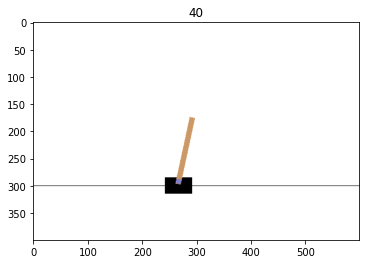

In [ ]:
def visual_episode(env, agent=None):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)

    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward

        plt.imshow(screen)
        plt.title(curr_t)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        curr_t = curr_t + 1

    ipythondisplay.clear_output(wait=True)
    env.close()
    return tot_reward

visual_episode(env)

500.0

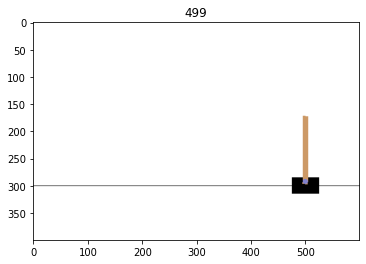

In [ ]:
visual_episode(env, agent)

### Running Agent - Running episode

In [ ]:
position = []
velocity = []
angle = []
rotation = []
x = []
curr_t = 0
tot_reward = 0.0
obs = env.reset()
agent.set_genes(best_gene)
#agent.set_genes(worst_gene)
done = False
while not done:
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
        
    tot_reward = tot_reward + reward
    curr_t = curr_t + 1

    #Appending obs values
    position.append(obs[0])
    velocity.append(obs[1])
    angle.append(obs[2])
    rotation.append(obs[3])
    x.append(curr_t)  

Text(0, 0.5, 'Position of Cart')

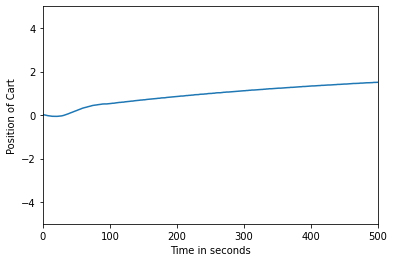

In [ ]:
#print(obs[0])
plt.plot(x,position,label = 'cart position')
plt.ylim(-5,5)
plt.xlim(0,500)
plt.xlabel("Time in seconds")
plt.ylabel("Position of Cart")       

Text(0, 0.5, 'Velocity of Cart')

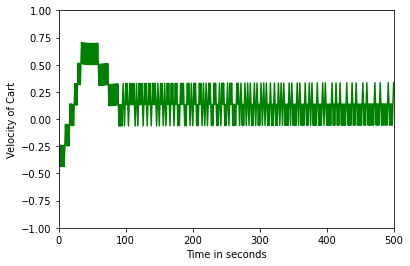

In [ ]:
#print(obs[1])
plt.plot(x,velocity,label = 'velocity',color ='green')
plt.ylim(-1,1)
plt.xlim(0,500)
plt.xlabel("Time in seconds")
plt.ylabel("Velocity of Cart")   

Text(0, 0.5, 'Angle of Pole')

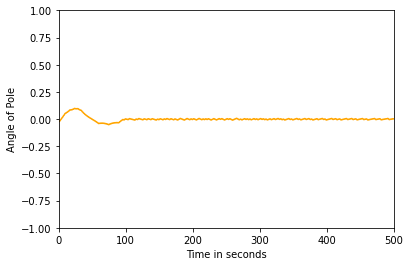

In [ ]:
plt.plot(x,angle,label = 'angle',color='orange')
plt.ylim(-1,1)
plt.xlim(0,500)
plt.xlabel("Time in seconds")
plt.ylabel("Angle of Pole")  

Text(0, 0.5, 'Rotation Rate of Pole')

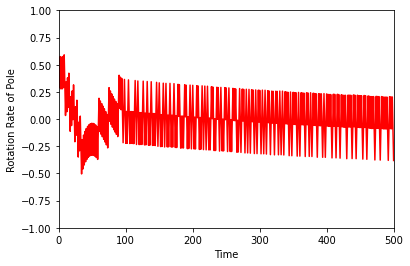

In [ ]:
#print(obs[3])
plt.plot(x,rotation,label = 'rotation rate',color='red')
plt.ylim(-1,1)
plt.xlim(0,500)
plt.xlabel("Time")
plt.ylabel("Rotation Rate of Pole")  

Accuracy of Pole and Position

### Extra Code
For help and testing 

In [ ]:
def select_genes(prev_gene_pop, gene_pop, prev_fitness, fitness):
    new_gene_pop = np.zeros_like(gene_pop)
    for i, gene in enumerate(gene_pop): 
        if fitness[i] >= prev_fitness[i]: 
            new_gene_pop[i] = gene_pop[i]
        else:
            new_gene_pop[i] = prev_gene_pop[i]

    return new_gene_pop

In [ ]:
def mutate(gene_pop,rate=0, std=0.1):
    for i,gene in enumerate(gen_pop):
      gene_pop[i] = gene_pop[i] + np.random.normal(mean, std, size=gene.shape)
    return geno_pop